### pytorch GPU分布式训练 单卡、多卡

### 单卡、DP、DDP相关介绍


**一、单卡训练**
原理：单卡训练是指模型完全运行在单个GPU上，数据加载、前向计算、反向传播和参数更新均在同一设备完成。  
流程：  
1. 数据加载：从存储介质（如本地磁盘或网络存储）读取数据到内存，并进行预处理（如数据增强）。  
2. 前向传播：将预处理后的数据送入GPU，完成模型的前向计算并生成预测结果。  
3. 损失计算：根据预测结果与真实标签计算损失值。  
4. 反向传播：通过损失值反向计算模型参数的梯度。  
5. 参数更新：使用优化器（如Adam）根据梯度更新模型参数。  

优化关键点：  
• 数据预取：通过多进程预加载数据，将I/O与计算并行化。  

• 显存管理：通过混合精度训练（FP16/BF16）减少中间结果的内存占用。  

• 计算效率：优化模型算子（如算子融合），提升GPU利用率。  


---

**二、数据并行（Data Parallelism, DP）**
原理：DP通过单进程多线程实现多卡训练，每个GPU保存完整的模型副本，数据被切分成多个子批次（mini-batch）分配到不同GPU上并行处理。  
流程：  
1. 数据分发：主GPU（通常为GPU 0）将数据划分为子批次并分发到其他GPU。  
2. 前向传播：各GPU独立完成前向计算和损失计算。  
3. 梯度同步：所有GPU将计算的梯度汇总到主GPU，主GPU对梯度求平均。  
4. 参数更新：主GPU更新模型参数，并将更新后的参数广播到其他GPU。  

优缺点：  
• 优点：实现简单，适合小规模多卡场景。  

• 缺点：  

  • 通信瓶颈：主GPU需处理所有梯度同步，扩展性差（GPU数量增加时效率显著下降）。  

  • 资源浪费：单进程无法充分利用多核CPU资源。  


典型应用：单机多卡训练，模型参数量较小且GPU数量较少时适用。

---

**三、分布式数据并行（Distributed Data Parallel, DDP）**
原理：DDP采用多进程架构，每个GPU对应独立进程，通过高效的通信算法（如Ring All-Reduce）实现梯度同步，避免中心节点瓶颈。  
流程：  
1. 进程初始化：每个进程绑定一个GPU，并加载相同的初始模型参数。  
2. 数据分片：使用分布式采样器（DistributedSampler）确保各进程读取不同的数据子集。  
3. 前向传播与梯度计算：各GPU独立完成前向计算和反向传播，生成本地梯度。  
4. 梯度同步：通过Ring All-Reduce算法，所有GPU协同完成梯度聚合与分发（无需主节点）。  
5. 参数更新：各GPU独立使用同步后的梯度更新本地模型参数（因初始参数和梯度一致，更新后参数仍保持一致）。  

Ring All-Reduce原理：  
• 将GPU排列成逻辑环，分两步完成通信：  

  1. Scatter-Reduce：梯度分段聚合，每个GPU逐步接收并累加部分梯度。  
  2. All-Gather：将聚合后的完整梯度分发给所有GPU。  

优缺点：  
• 优点：  

  • 高扩展性：通信开销与GPU数量无关，支持千卡级训练。  

  • 资源利用：多进程架构充分利用多核CPU和GPU资源。  

• 缺点：  

  • 实现复杂：需管理多进程和通信逻辑。  

  • 调试难度：多进程环境下的错误定位较困难。  


典型应用：大规模分布式训练（单机/多机多卡），如BERT、GPT等大模型。

---

**四、DP与DDP的对比**
| 特性       | DP                     | DDP                     |
|----------------|----------------------------|-----------------------------|
| 进程模型   | 单进程多线程               | 多进程（每GPU一进程）       |
| 通信方式   | 主GPU集中式同步（参数服务器） | 分布式同步（Ring All-Reduce）|
| 扩展性     | 差（GPU增加时效率下降）     | 优（支持大规模扩展）        |
| 资源利用   | CPU多核利用不足             | 充分调用多核CPU和GPU        |
| 适用场景   | 小规模单机多卡             | 大规模单机/多机训练         |



### 安装前提环境

#### 系统环境

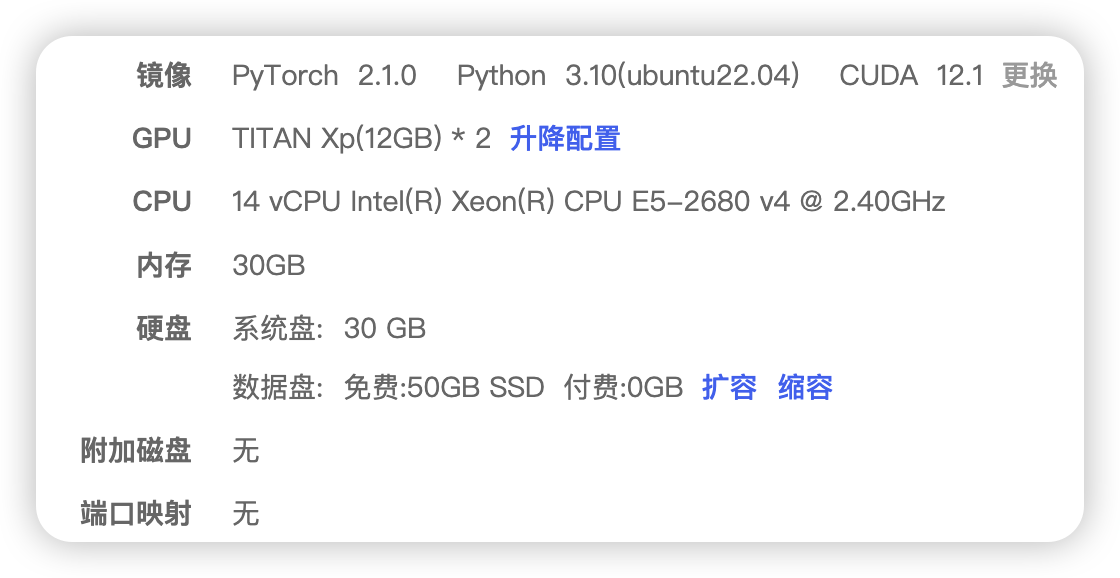
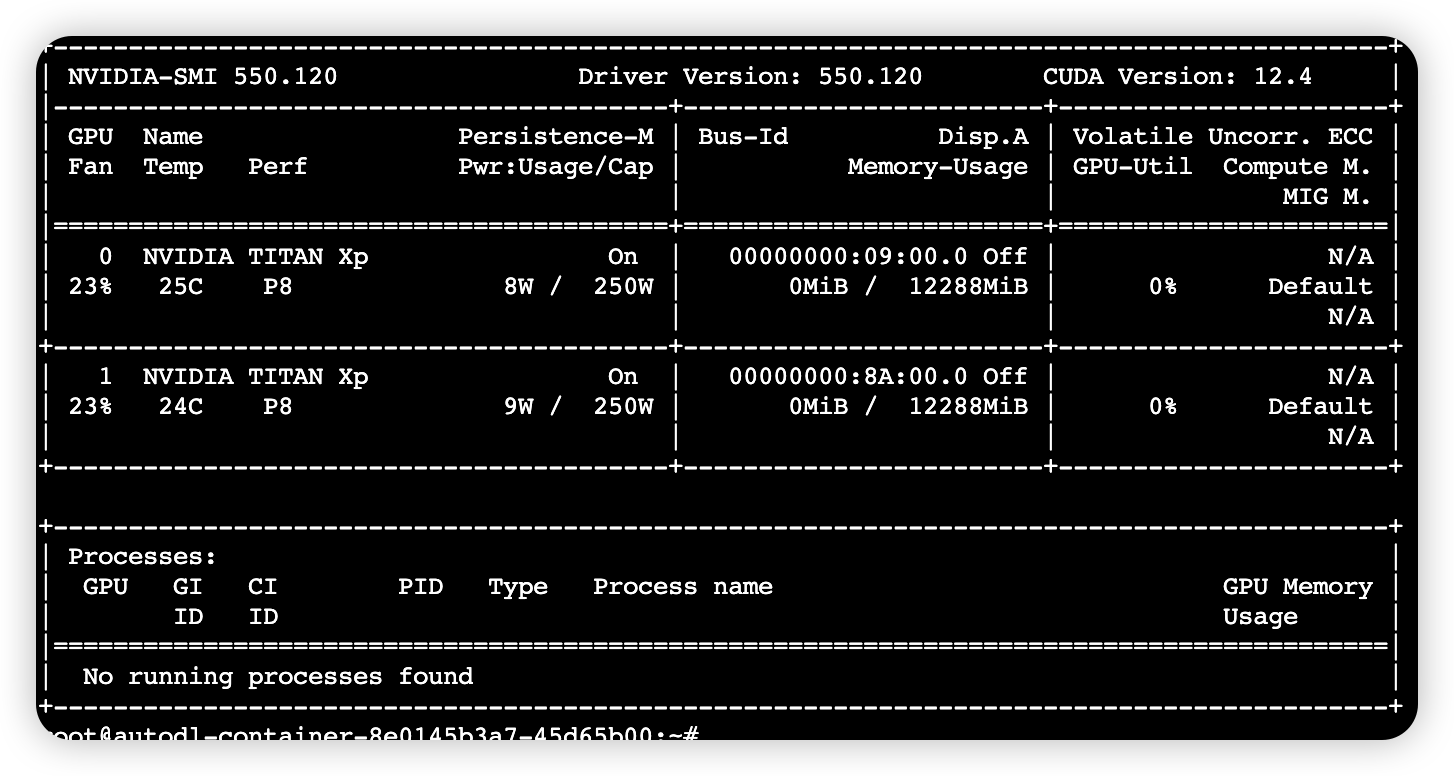

#### 安装相关python库

In [ ]:
!pip install torch torchvision matplotlib


In [1]:
import torch
print(torch.cuda.nccl.version())  # 应该返回 NCCL 版本号


(2, 18, 6)


### 一、单卡训练

In [9]:
#导入环境
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# 检查GPU是否可用，以及当前 GPU 数量
device = "cuda" if torch.cuda.is_available() else "cpu"
print("当前设备:", device)
print("GPU数量：", torch.cuda.device_count())

当前设备: cuda
GPU数量： 2


In [4]:
#下载数据集
# 1. 定义数据转换（预处理）
transform = transforms.Compose([
    transforms.ToTensor(),          # 转为Tensor格式（自动归一化到0-1）
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化（MNIST的均值和标准差）
])

# 2. 下载数据集
train_data = datasets.MNIST(
    root='./data',          # 数据存储路径
    train=True,           # 训练集
    download=True,        # 自动下载
    transform=transform   # 应用预处理
)

test_data = datasets.MNIST(
    root='./data',
    train=False,          # 测试集
    transform=transform
)

# 3. 创建数据加载器（自动分批次）
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 4213413.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 120947.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:07<00:00, 230379.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1910785.23it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# 查看数据形状示例
images, labels = next(iter(train_loader))
print("图片形状:", images.shape)  # torch.Size([64, 1, 28, 28]) → 64张1通道的28x28图片

图片形状: torch.Size([64, 1, 28, 28])


In [6]:
#定义模型结构
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 卷积层组合
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),   # 输入1通道，输出32通道，3x3卷积核
            nn.ReLU(),              # 激活函数
            nn.MaxPool2d(2),        # 最大池化（缩小一半尺寸）

            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Flatten(),           # 展平多维数据
            nn.Linear(64*5*5, 128), # 输入维度需要计算（后面解释）
            nn.ReLU(),
            nn.Linear(128, 10)      # 输出10个数字的概率
    )

    def forward(self, x):
        x = self.conv_layers(x)     # 通过卷积层
        x = self.fc_layers(x)       # 通过全连接层
        return x


# 创建模型实例并转移到设备
model = CustomModel().to(device)
print(model)

CustomModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
#定义 损失函数，优化器，训练次数
criterion = nn.CrossEntropyLoss()          # 损失函数（分类任务常用）
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 优化器（自动调节学习率）

epochs = 20

Epoch 1/20 损失: 0.0035
Epoch 2/20 损失: 0.0034
Epoch 3/20 损失: 0.0035
Epoch 4/20 损失: 0.0037
Epoch 5/20 损失: 0.0035
Epoch 6/20 损失: 0.0018
Epoch 7/20 损失: 0.0012
Epoch 8/20 损失: 0.0054
Epoch 9/20 损失: 0.0046
Epoch 10/20 损失: 0.0014
Epoch 11/20 损失: 0.0012
Epoch 12/20 损失: 0.0020
Epoch 13/20 损失: 0.0042
Epoch 14/20 损失: 0.0034
Epoch 15/20 损失: 0.0016
Epoch 16/20 损失: 0.0008
Epoch 17/20 损失: 0.0028
Epoch 18/20 损失: 0.0031
Epoch 19/20 损失: 0.0011
Epoch 20/20 损失: 0.0033


/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.prin

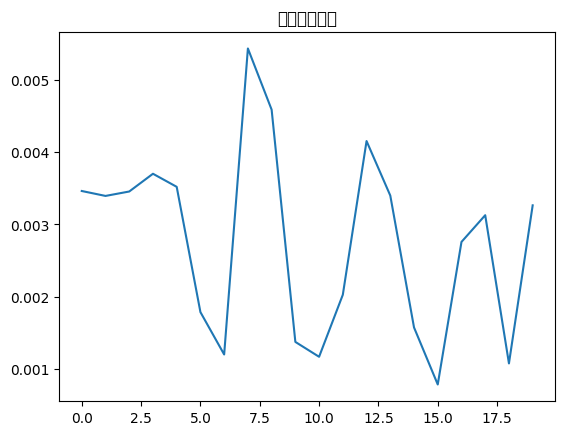

In [10]:
#定义训练函数，开始 单卡 训练
def trainModel(model):
    train_losses = []
    
    for epoch in range(epochs):
        model.train()  # 设置为训练模式
        running_loss = 0.0
    
        for images, labels in train_loader:
            # 数据转移到设备（GPU/CPU）
            images, labels = images.to(device), labels.to(device)
    
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # 反向传播
            optimizer.zero_grad()  # 清空之前的梯度
            loss.backward()        # 计算梯度
            optimizer.step()       # 更新参数
    
            running_loss += loss.item()
    
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} 损失: {epoch_loss:.4f}")
    
    # 绘制损失曲线
    plt.plot(train_losses)
    plt.title("训练损失变化")
    plt.show()

    return model

#开始训练

#开始训练时间
start = time.perf_counter()
model = trainModel(model)
end = time.perf_counter()


In [11]:
#训练时间
print(f"单卡训练使用时间: {end - start} 秒")

单卡训练使用时间: 360.91261252760887 秒


#### 运行过程中显卡占用
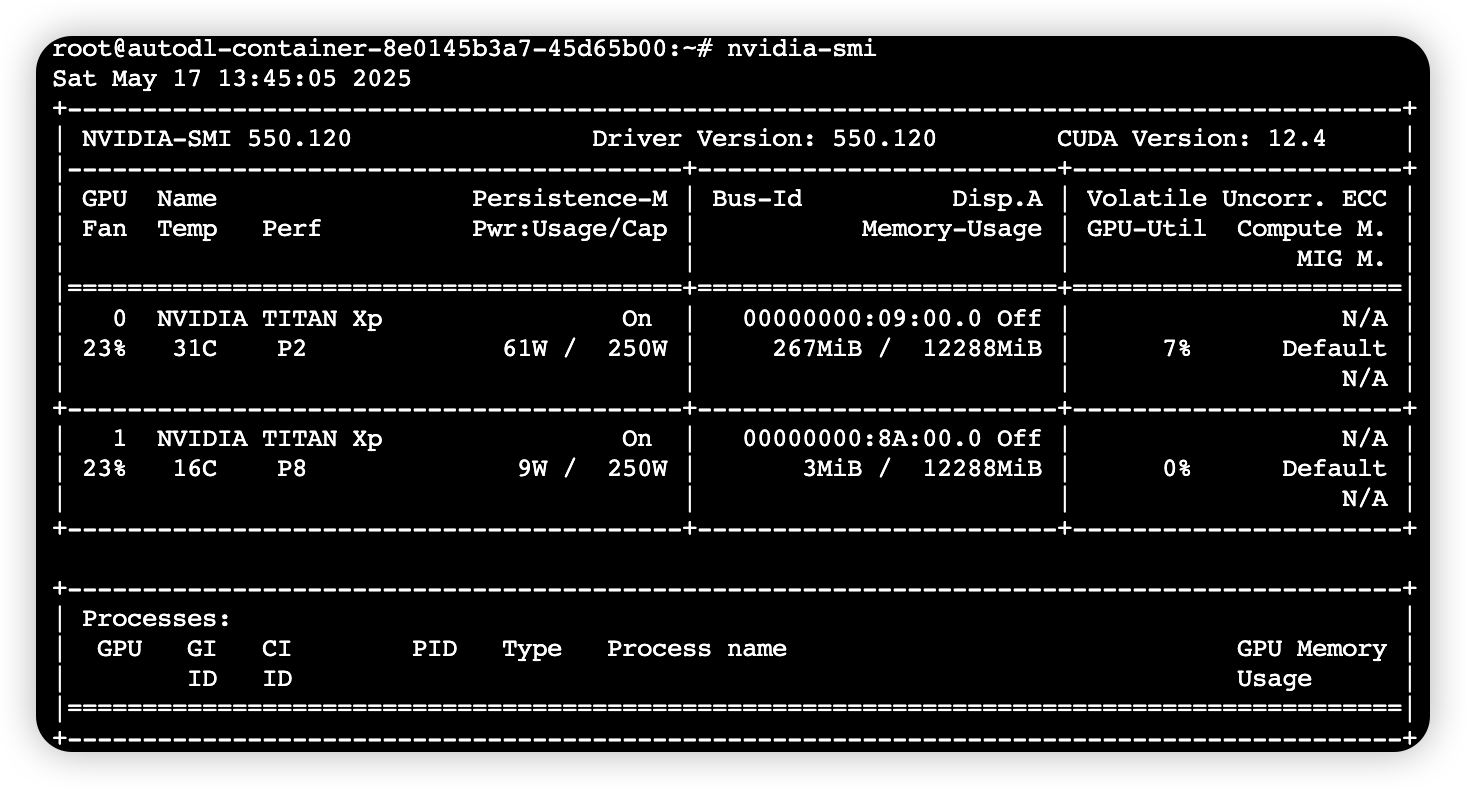

### 二、多卡训练

#### 1、DP 训练


导入torch.nn.DataParaller，将原始模型进行包裹，其余代码完全一样

In [16]:
#相比于 单卡训练，新增导入环境
from torch.nn import DataParallel

In [18]:
# 将 单卡训练模型 改为 DP 训练
#device_ids 表示 GPU 的序号
DP_model = DataParallel(model, device_ids=[0, 1])
DP_model.to("cuda")

DataParallel(
  (module): CustomModel(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1600, out_features=128, bias=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)

Epoch 1/20 损失: 0.0035
Epoch 2/20 损失: 0.0009
Epoch 3/20 损失: 0.0017
Epoch 4/20 损失: 0.0027
Epoch 5/20 损失: 0.0012
Epoch 6/20 损失: 0.0002
Epoch 7/20 损失: 0.0000
Epoch 8/20 损失: 0.0000
Epoch 9/20 损失: 0.0000
Epoch 10/20 损失: 0.0000
Epoch 11/20 损失: 0.0000
Epoch 12/20 损失: 0.0000
Epoch 13/20 损失: 0.0000
Epoch 14/20 损失: 0.0000
Epoch 15/20 损失: 0.0000
Epoch 16/20 损失: 0.0000
Epoch 17/20 损失: 0.0000
Epoch 18/20 损失: 0.0000
Epoch 19/20 损失: 0.0000
Epoch 20/20 损失: 0.0000


/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.prin

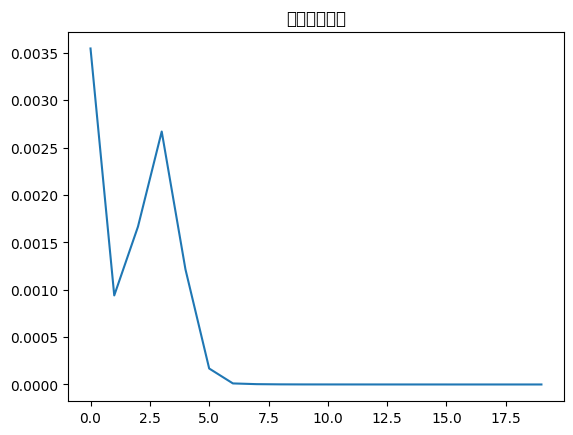

In [19]:

#开始训练,并计算时间
start = time.perf_counter()
DP_model = trainModel(DP_model)
end = time.perf_counter()

In [20]:
#训练时间
print(f"DP训练使用时间: {end - start} 秒")

DP训练使用时间: 575.9450940731913 秒


##### 运行过程中，显卡占用情况
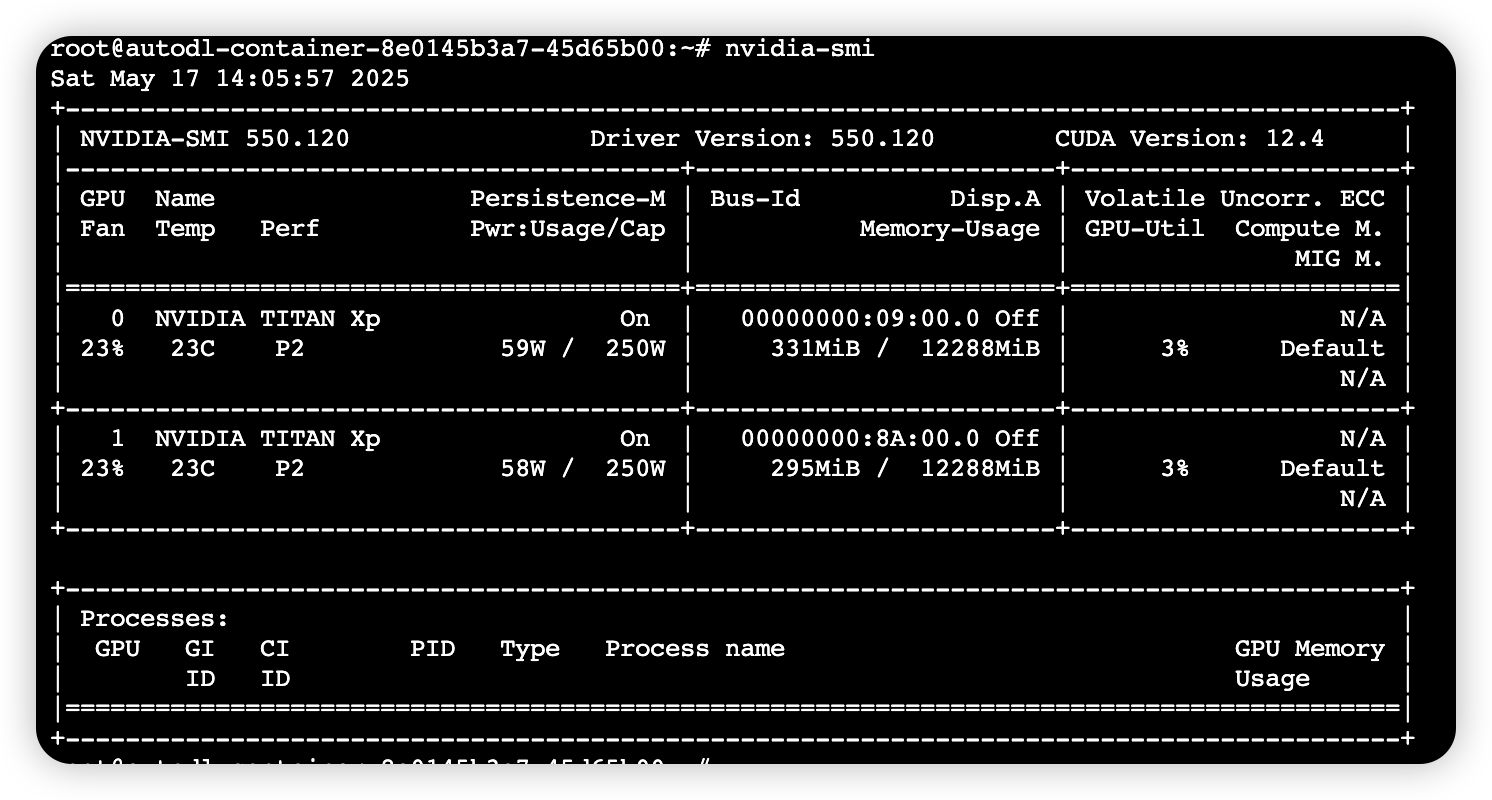

#### 2、DDP 训练（使用命令行启动）

In [ ]:
#加载数据集需要修改，具体修改如下:
#world_size:总 GPU 个数
#local_rank：当前 GPU 编号
def load_data(world_size,local_rank):
    #下载数据集
    # 1. 定义数据转换（预处理）
    transform = transforms.Compose([
        transforms.ToTensor(),          # 转为Tensor格式（自动归一化到0-1）
        transforms.Normalize((0.1307,), (0.3081,))  # 标准化（MNIST的均值和标准差）
    ])
    
    # 2. 下载数据集
    train_data = datasets.MNIST(
        root='./data',          # 数据存储路径
        train=True,           # 训练集
        download=True,        # 自动下载
        transform=transform   # 应用预处理
    )
    
    test_data = datasets.MNIST(
        root='./data',
        train=False,          # 测试集
        transform=transform
    )

    # 2.1 配置分布式采样器（确保不同GPU获取不同数据子集）
    train_sampler = DistributedSampler(train_data, num_replicas=world_size, rank=local_rank)
    test_sampler = DistributedSampler(test_data, num_replicas=world_size, rank=local_rank)
    # 3. 创建数据加载器（自动分批次）
    train_loader = DataLoader(train_data, batch_size=64, shuffle=False, sampler = train_sampler)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, sampler = test_sampler)

    return train_loader, test_loader, train_sampler, test_sampler

In [ ]:
#因为 使用命令行启动训练，需要 接收命令后参数，主函数main中的最上方位置添加下述代码
#设置参数local_rank
local_rank = int(os.environ.get("LOCAL_RANK", 0))

In [ ]:
#初始化 分布式 环境
torch.distributed.init_process_group("nccl")
torch.cuda.set_device(local_rank) # 绑定当前进程到指定GPU

In [ ]:
#原始模型需要包装 为 DDP
# 创建模型实例
device = torch.device(f"cuda:{local_rank}")
model = CustomModel().to(device)

#原始模型 包装 为 DDP
DDP_model = DDP(model, device_ids=[local_rank], output_device=local_rank)

In [ ]:
#训练过程需要 修改，具体训练如下
for i in range(epoch):
    print("------第 {} 轮训练开始------".format(i+1))

    train_sampler.set_epoch(epoch) #每张卡在每个周期上的值是随机的，设置epoch保证shuffle有效性

    DDP_model.train()
    for batch in train_loader:
        inputs,labels = batch

        #将数据赋值到 local_rank
        inputs = inputs.cuda(local_rank, non_blocking=True)
        labels = labels.cuda(local_rank, non_blocking=True)

        #记录 单批数据 训练时间
        starttime = time.time()
        
        outputs = DDP_model(inputs)
        
        loss = loss_fn(outputs, labels)
        
        optimize.zero_grad()
        
        loss.backward()
        
        optimize.step()
        
        endtime = time.time()

        train_step=train_step+1
        if train_step%1==0:
            print("训练次数:{},Loss:{},time:{}".format(train_step,loss.item(),endtime-starttime))

    #仅在local_rank == 0时保存
    if local_rank ==0:
        torch.save(DDP_model,"DDP_model_{}.pth".format(i))
    print("模型已保存")

In [ ]:
#DDP_train.py 完整代码如下：

In [ ]:
'''
DDP训练启动命令

# 单机双卡启动命令
torchrun \
    --nproc_per_node=2 \  # 使用2个GPU
    --nnodes=1 \          # 单机模式
    --node_rank=0 \       # 当前机器rank
    --master_addr="127.0.0.1" \
    --master_port=12345 \
    ddp_mnist.py（文件名）
'''


#导入环境
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

#导入 DDP训练 需要的环境
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from torch.utils.data.distributed import DistributedSampler
import argparse #读取命令行参数
from torch.nn.parallel import DistributedDataParallel as DDP

def load_data(world_size,local_rank):
    #下载数据集
    # 1. 定义数据转换（预处理）
    transform = transforms.Compose([
        transforms.ToTensor(),          # 转为Tensor格式（自动归一化到0-1）
        transforms.Normalize((0.1307,), (0.3081,))  # 标准化（MNIST的均值和标准差）
    ])
    
    # 2. 下载数据集
    train_data = datasets.MNIST(
        root='./data',          # 数据存储路径
        train=True,           # 训练集
        download=True,        # 自动下载
        transform=transform   # 应用预处理
    )
    
    test_data = datasets.MNIST(
        root='./data',
        train=False,          # 测试集
        transform=transform
    )

    # 2.1 配置分布式采样器（确保不同GPU获取不同数据子集）
    train_sampler = DistributedSampler(train_data, num_replicas=world_size, rank=local_rank)
    test_sampler = DistributedSampler(test_data, num_replicas=world_size, rank=local_rank)
    # 3. 创建数据加载器（自动分批次）
    train_loader = DataLoader(train_data, batch_size=64, shuffle=False, sampler = train_sampler)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, sampler = test_sampler)

    return train_loader, test_loader, train_sampler, test_sampler


#定义模型结构
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 卷积层组合
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),   # 输入1通道，输出32通道，3x3卷积核
            nn.ReLU(),              # 激活函数
            nn.MaxPool2d(2),        # 最大池化（缩小一半尺寸）

            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Flatten(),           # 展平多维数据
            nn.Linear(64*5*5, 128), # 输入维度需要计算（后面解释）
            nn.ReLU(),
            nn.Linear(128, 10)      # 输出10个数字的概率
    )

    def forward(self, x):
        x = self.conv_layers(x)     # 通过卷积层
        x = self.fc_layers(x)       # 通过全连接层
        return x

if __name__=="__main__":
    #设置参数args.local_rank
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--local_rank", help = "local device id on current node", type = int)
    # args = parser.parse_args()


    local_rank = int(os.environ.get("LOCAL_RANK", 0))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    world_size = torch.cuda.device_count()
    
    if torch.cuda.is_available():
        # 检查GPU是否可用，以及当前 GPU 数量
        print("当前设备:", device)
        print("GPU数量：", world_size)
    else:
        print("GPU 不能使用")
        raise Exception("GPU 不能使用")


    torch.distributed.init_process_group(backend="nccl")
    torch.cuda.set_device(local_rank) # 绑定当前进程到指定GPU

    #加载数据集
    train_loader, test_loader, train_sampler, test_sampler = load_data(world_size, local_rank)

    #模型载入args.local_rank
    # 创建模型实例
    device = torch.device(f"cuda:{local_rank}")
    model = CustomModel().to(device)

    #原始模型 包装 为 DDP
    DDP_model = DDP(model, device_ids=[local_rank], output_device=local_rank)
    #定义 损失函数，优化器，训练次数
    loss_fn = nn.CrossEntropyLoss()          # 损失函数（分类任务常用）
    optimize = optim.Adam(model.parameters(), lr=0.001)  # 优化器（自动调节学习率）
    
    train_step=0
    test_step=0
    epoch=10


    #开始训练
    #开始训练时间
    start = time.perf_counter()
    
    for i in range(epoch):
        print("------第 {} 轮训练开始------".format(i+1))
 
        train_sampler.set_epoch(epoch) #每张卡在每个周期上的值是随机的，设置epoch保证shuffle有效性
 
        DDP_model.train()
        for batch in train_loader:
            inputs,labels = batch
 
            #将数据赋值到args.local_rank
            inputs = inputs.cuda(local_rank, non_blocking=True)
            labels = labels.cuda(local_rank, non_blocking=True)

            #记录 单批数据 训练时间
            starttime = time.time()
            
            outputs = DDP_model(inputs)
            
            loss = loss_fn(outputs, labels)
            
            optimize.zero_grad()
            
            loss.backward()
            
            optimize.step()
            
            endtime = time.time()
    
            train_step=train_step+1
            if train_step%100==0:
                print("训练次数:{},Loss:{},time:{}".format(train_step,loss.item(),endtime-starttime))
 
        #仅在alocal_rank == 0时保存
        if local_rank ==0:
            torch.save(DDP_model,"DDP_model_{}.pth".format(i))
        print("模型已保存")

    end = time.perf_counter()

    #训练时间
    print(f"DDP训练使用时间: {end - start} 秒")
    
    # 清理分布式环境
    torch.distributed.destroy_process_group()

##### 训练时间
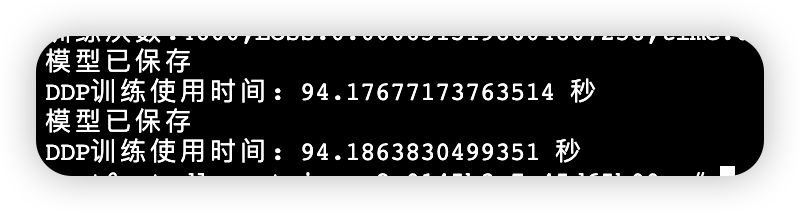

##### 运行过程中，显卡占用情况
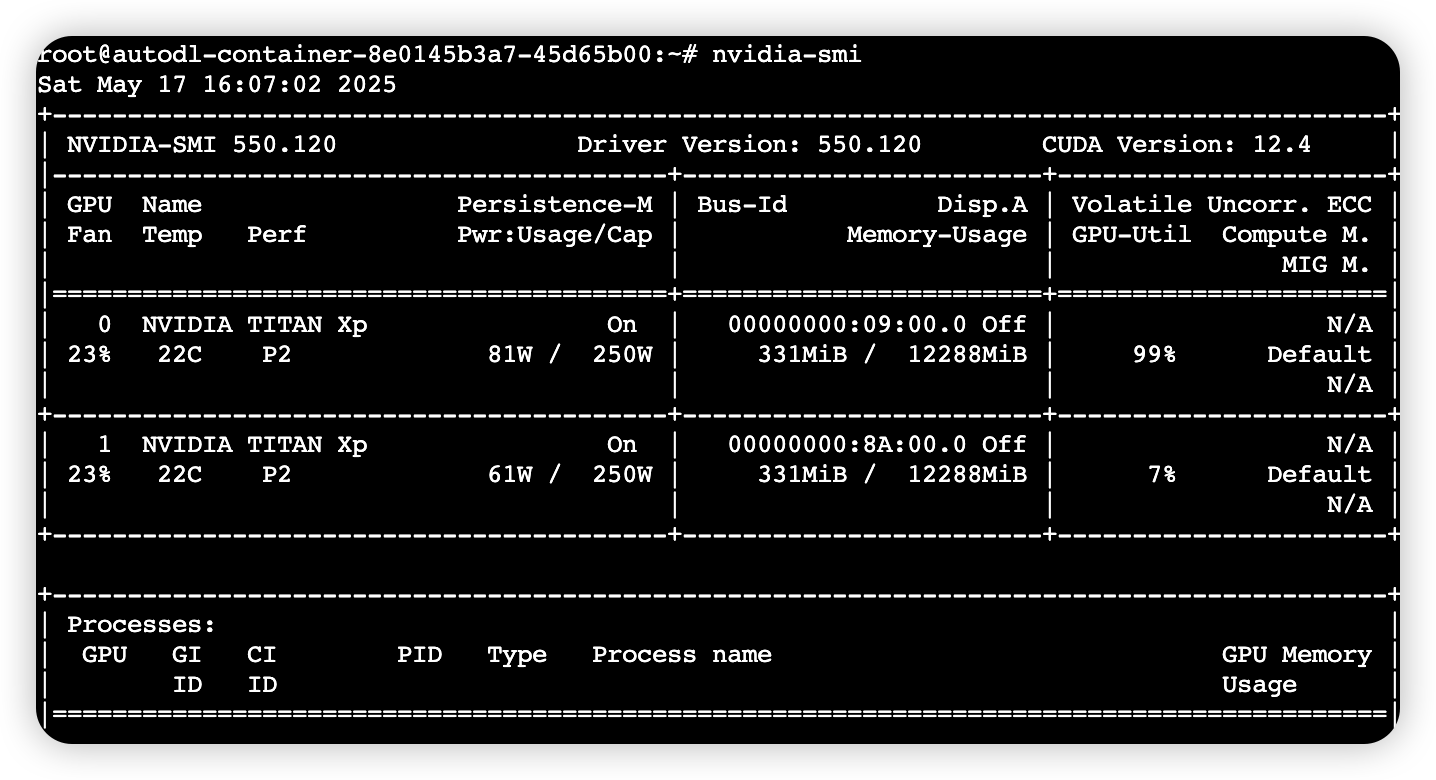

In [ ]:
#评估
model.eval()  # 设置为评估模式
correct = 0
total = 0

with torch.no_grad():  # 不计算梯度（节省内存）
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # 取概率最大的类别
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"测试集准确率: {100 * correct / total:.2f}%")


# 随机选择一张测试图片
index = np.random.randint(0,1000)  # 可以修改这个数字试不同图片
test_image, true_label = test_data[index]
test_image = test_image.unsqueeze(0).to(device)  # 增加批次维度

# 预测
with torch.no_grad():
    output = model(test_image)
predicted_label = torch.argmax(output).item()

# 显示结果
plt.imshow(test_image.cpu().squeeze(), cmap='gray')
plt.title(f"预测: {predicted_label}, 真实: {true_label}")
plt.show()